# **Text Mining with Python 3**
<br><br><br>
*Filippo Olivi*

*The analysis was done as part of the UNCC Senior Project course*


***

## **What this guide/analysis is about**<br><br><br>

Text Mining is the process which acts on text and results in the extraction of quality, focused, and/or statistical data.

**Sources/Help received from:**<br>
<br>
The analysis is done extracting data from the body of several articles, stored on [MongoDB](https://www.mongodb.com/). The dataset is provided by [Kaggle](https://www.kaggle.com/datasets).
Moreover, I got some inspiration and help from another guide on [Datacamp](https://www.datacamp.com/community/tutorials/wordcloud-python) for working with graphics, in particular a WordCloud, and the very first pre-processing part.

**About the guide:**<br>
<br>
This is a guide to basic text mining, based on my experience working on a Senior Project on my senior year at UNCC. 
It is meant in part to record and revisit my steps in making this project, in part to provide help and insight about how to start an analysis on the topic, since text mining as a whole is a really broad one, and feeling a bit lost at the start would be normal. 
Here you will see how I decided to set it up and which tools I used or considered using.

**About the analysis:**<br>
<br>
This particular analysis is supposed to be performed on a dataset filled with IT job postings. The purpose is to actually look into the text body of the post, search and filter them all to get some insight into a few things that might be of interest to anyone looking for a job. However, this analysis was first performed on a test dataset, which includes articles about a lot of different IT topics. While not necessarily always resulting in skills required for jobs, it was pretty close to what the end result would eventually be.<br>

In particular, the data I wanted to extract was:
     - The most mentioned IT skills, aka the most required ones
     - The most popular combinations of IT skills, to make useful pairings

***

## **Tools / Packages used**<br><br><br>

**For text processing:**
<br>
 * [NumPy](https://numpy.org/) for general scientific computing purpose, mostly used for N-dimensional arrays
 * [Pandas](https://pandas.pydata.org/) is one of the best libraries for data science, featuring the fundamental DataFrame object, that considerably helps for storing the articles retrieved from the collection
 * [Matplotlib](https://matplotlib.org/) is essential for creating visualizations for a more comprehensive analysis, such as graphs
 * [NLTK](https://www.nltk.org/) or Natural Language Toolkit, is a very useful tool to process all the neutral text as it is found in the articles. Processing before running the actual queries is maybe the most crucial step in order for it to result in a clean and excellent analysis. Actual examples of what this can do is eliminating stopwords (words that are not to be included, like "like/as/the/is/at/etc...")
 
**For fancy graphics:**
<br>
 * [WordCloud](https://github.com/amueller/word_cloud) is a tool developed by "amueller" that allows to print the particular graphic showing the most used words all together in a chosen shape
 
**For database/script mediation:**
<br>
 * [PyMongo](https://pymongo.readthedocs.io/en/stable/) is the Python distribution that permits to easily interact with MongoDB using Python

***

## **1.**
## **Importing the tools**<br><br><br>

Nothing particularly difficult here.<br> 
<br>
Even though the guide goes in order from the start to the end of the script, *importing all the packages was not done all at the very beginning*, because you could not know what exactly you would need.

So, this part started with just a few of these statements, and got filled as the script was being written.

In [ ]:
# Import all the modules/packages needed first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
set(stopwords.words('english'))
from nltk.tokenize.treebank import TreebankWordDetokenizer

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pymongo
from pymongo import MongoClient

***


## **2.**
## **Two ways to access data**<br><br><br>

**From a csv file:**<br>
<br>
Initially, I started doing the analysis locally on my end. The actual dataset was downloaded from Kaggle as a csv file called "articles.csv", and Pandas provides a very useful function called **read_csv** that allows you to read from the file.

Very easily, since the file resides on the same folder as the script, only one line of code was needed to access the data and make a DataFrame object out of it:

In [2]:
# Using Pandas .read_csv to read the file
dataFrame = pd.read_csv("articles.csv")

**From MongoDB:**<br>
<br>
However this was not optimal as I wanted to access data directly from the database and collection hosted on a server I have access to, which uses MongoDB. For this reason, using **PyMongo** was essential in making the connection between the script and the database.

The only thing to be way of is that a *MongoDB must obviously be active on the server before*.

Here is the code that nets the same result as the csv method:

In [ ]:
# A MongoDB instance must be running before, activate with: mongod
# Connects to the default host and port
client = MongoClient()

# Uses the database name instead of test, which in this particular case is the db
db = client.test 
collection = db.articles                        

# Using Pandas DataFrame object to read the file              
dataFrame = pd.DataFrame(list(collection.find()))

Now that we have our **DataFrame Pandas object** (which includes all the articles in the dataset) comfortably ordered, we can start processing the data!

***


## **3.**
## **Fiddling with the dataset**<br><br><br>

Before starting the analysis, I thought it would be important to play around a bit with the dataset.

Doing this, I could easily get familiar with:

 * The structure of the dataset
 * How to use some basic Pandas, NumPy and Matplotlib functions

For this first part of it, the Datacamp guide (mentioned and linked in the sources) had a lot of great ways to get a nice first look into the dataset, which I used too here, adapted to my set:

In [3]:
# Look at the first 5 entries of the dataset with Pandas .head() method
dataFrame.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


In [4]:
# See how many entries its got. .shape[0] gives rows, .shape[1] gives columns 
print(f'There are {dataFrame.shape[0]} entries in this dataset')

There are 337 entries in this dataset


In [5]:
# How many unique authors, using the Pandas unique function
print(f'There are {len(dataFrame.author.unique())} unique authors in this dataset')

There are 182 unique authors in this dataset


In [6]:
# Make another dataset called author, where all entries are grouped by author name and with only certain columns
author = dataFrame[["author", "claps", "reading_time", "title"]].groupby("author")

author.describe().head()

reading_time                                            \
                          count   mean       std   min    25%   50%   75%   
author                                                                      
Abhishek Parbhakar          4.0   5.25  1.500000   3.0   5.25   6.0   6.0   
Adam Geitgey               16.0  14.25  1.570563  11.0  13.00  15.0  15.0   
Ahmed El Deeb               2.0   5.00  2.828427   3.0   4.00   5.0   6.0   
AirbnbEng                   2.0  10.00  1.414214   9.0   9.50  10.0  10.5   
Akash Shende                1.0   3.00       NaN   3.0   3.00   3.0   3.0   

                          
                     max  
author                    
Abhishek Parbhakar   6.0  
Adam Geitgey        16.0  
Ahmed El Deeb        7.0  
AirbnbEng           11.0  
Akash Shende         3.0

In [7]:
# Sort the dataframe showing only the highest 5 reading times. Notice that an article was posted 2 times.
dataFrame.sort_values(by = "reading_time", ascending = False).head()

,author,claps,reading_time,link,title,text
106,Paul Christiano,43,31,https://ai-alignment.com/a-formalization-of-in...,Formalizing indirect normativity – AI Alignment,This post outlines a formalization of what Nic...
27,Paul Christiano,43,31,https://ai-alignment.com/a-formalization-of-in...,Formalizing indirect normativity – AI Alignment,This post outlines a formalization of what Nic...
274,Leigh Alexander,2.7K,31,https://medium.com/@leighalexander/the-future-...,The Future We Wanted – Leigh Alexander – Medium,I wonder a lot about how Jane ended up. When w...
311,Rohan Kapur,1K,30,https://ayearofai.com/rohan-lenny-1-neural-net...,Rohan & Lenny #1: Neural Networks & The Backpr...,"In Rohan’s last post, he talked about evaluati..."
209,Gary Marcus,1.3K,27,https://medium.com/@GaryMarcus/in-defense-of-s...,In defense of skepticism about deep learning –...,In a recent appraisal of deep learning (Marcus...


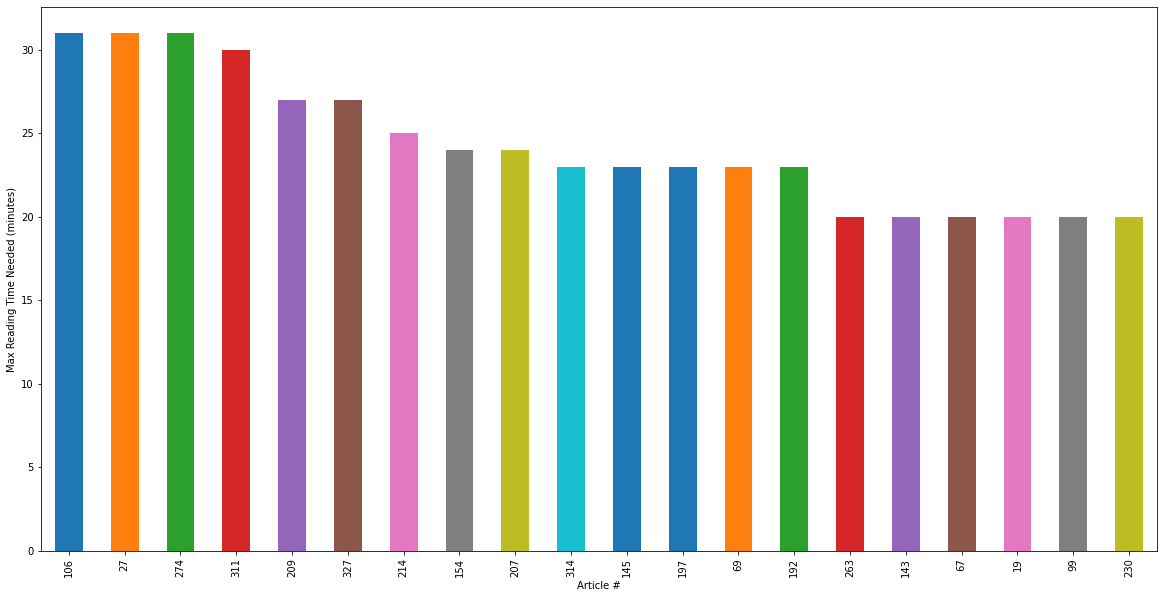

In [8]:
# Using MathPlotLib we set the dimensions of the graph
plt.figure(figsize = (20, 10))

# With Pandas plot the top 20 reading times sorted by highest ones
dataFrame.sort_values(by = "reading_time", ascending = False)["reading_time"].head(20).plot.bar()

# Set label for the axes
plt.xlabel("Article #")
plt.ylabel("Max Reading Time Needed (minutes)")

plt.show()

Since I got to the point of drawing a graph, I figured this might have been the time to try drawing a **wordcloud**. 
Following the Datacamp guide and looking into the WordCloud documentation myself I found out that using the library is pretty simple.

*The first wordcloud I made was only considering the text of the first article, just to try it out.*

While the "wordcloud1" object is created with the WordCloud function using the default stopwords, we use Matplotlib to print it, specifying the size.

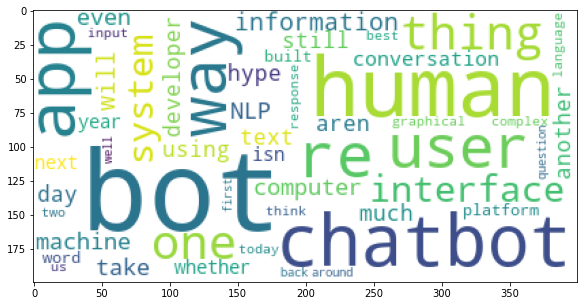

In [9]:
# Let's make a WordCloud with the most common words from the first article. We can also use the set of stopwords provided by
# NLTK, or if undeclared, the default ones
firstArticle = dataFrame.text[0]
wordcloud1 = WordCloud(max_words = 50, background_color = "white").generate(firstArticle)

# Now show it with MathPlotLib
plt.figure(figsize = (15, 5))
plt.imshow(wordcloud1)

#### *Pretty cool!*

The mask can modified a lot, using different shapes and colors but for now that's not what this guide is focusing on.

If you are interested in more styles for your wordcloud, check out the Datacamp guide linked in the Sources section!

***


## **4.**
## **Processing the text**<br><br><br>

**Processing is the most important part** now, because it is about cleaning out the text to avoid misleading and/or incorrect results. 
In fact, the deeper you go and the more accurate and meticulous you are with this part, the better your output will be at the end.

I will divide this part in 3, to make it easier to follow.

**4.1 - A huge article:**<br>
<br>
The first wordcloud only used the first article, but now that I am about to clean the text, it is time to work on all the articles, because the data I want to pull out has to be from the *whole dataset*!

So, the **first step is to chain together every entry of the dataset into one big article**:

In [10]:
# First we join all the articles
allArticles = " ".join(article for article in dataFrame.text).lower()

# Let's check how many words are there
print(f'Between all articles, there are {len(allArticles)} words')

Between all articles, there are 3747830 words


As we can see, now we have one huge article with all the words, and we can move onto the next step.

**4.2 - Custom stopwords:**<br>
<br>
Stopwords are very important, and *setting them properly is the very core of our cleaning process* here, because these are the irrelevant words we will have to take out of the text.

What I did was using the NLTK default stopwords as a base, and added my own customized stopwords too.

**NOTE:** *This was mostly done by trial and error by seeing the end result first, and adding more stopwords time and time again.*

In [11]:
# Let's set the NLTK default stopwords
stop_words_base = set(stopwords.words('english'))

# Now we add more, because the default ones were not enough
numbers_stop_words = set(('one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'first', 'second',
                         'third', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

more_stop_words = set(('like', 'would', 'use', 'also', 'much', 'us', 'get', 'way', 'new', 'could', 'much', 'many', 'could',
                      'make', 'even', 'want', 'see', 'still', 'need', 'used', 'learn', 'time', 'using'))

# Now we add them all together
stop_words = stop_words_base | numbers_stop_words | more_stop_words

**4.3 - Tokenizing into a very clean list of words:**<br>
<br>
At this point, for analysing all the text word by word, I figured I could use a list of words and look into every single one of them. 

Transforming a string into a list of words is called **Tokenizing**, and in this case, we can exclude all the punctuation that evaded our stopwords check before, all at one time:

In [12]:
# Revised stopwords without punctuation
no_punct = RegexpTokenizer(r'\w+')

# Tokenize all the articles, now without any punctuation
allArticles_withoutPunct = no_punct.tokenize(allArticles)

# Now let's create a new and clean list, without stopwords or punctuation
articles_tokens_clean = []

# Loop to check for stopwords and fill the list
for word in allArticles_withoutPunct:
    if word not in stop_words:
        articles_tokens_clean.append(word)

Since we have the filled list, clean and completely without stopwords, let's check how many words it has now:

In [13]:
# Let's check how many USEFUL words are there after the cleaning
print(f'Between all articles, there are {len(articles_tokens_clean)} useful words')

Between all articles, there are 324182 useful words


The articles have now been synthetized to a little more than 300 thousand words. 

#### *A huge improvement, considering how before cleaning it up, it almost reached 4 million!*

***

## **5.**
## **Queries and a final wordcloud**<br><br><br>

Finally having our processed list of all the words of every article and before running the queries, I wanted to take another shot at making a new wordcloud.

*This time, it will use both the default stopwords and the already processed list of all the articles*, which will need to be detokenized back into text before (just for the wordcloud):

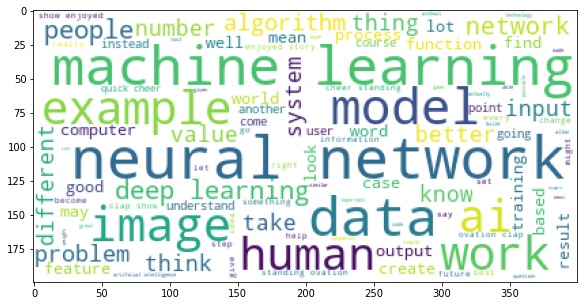

In [14]:
# Now let's detokenize the list to create a wordcloud later
clean_text = TreebankWordDetokenizer().detokenize(articles_tokens_clean)

# Now like before, we make a wordcloud
total_wordcloud = WordCloud(background_color = "white", max_words = 100).generate(clean_text)

plt.figure(figsize = (15, 5))
plt.imshow(total_wordcloud)

Much better than the old one, now we can see a lot of terms that refer to the skills we are looking for in this analysis.

#### *Time to run the queries!*

**5.1 - Top 10 most common words:**<br>
<br>
For this one, we need to change the list into a dictionary, where:

- key = Word
- value = How many times the word appeared in total

In [15]:
# Now lets use the tokenized list and make into a dictionary (clear of stopwords) to find the count of the 10 most used words
most_common_ten = dict(Counter(articles_tokens_clean).most_common(10))

We can now easily print our skills and their presence percentage using a for loop and the **"items()" function**:

In [16]:
# Now lets print the most common ten words first
print(f'The 10 most common words across all articles are:\n')

# Print frequencies and data from the dictionary
for item, count in most_common_ten.items(): 
    print(f'{item}: These skills appeared {count} times, or {((count*100)/len(articles_tokens_clean)):.4f}% of all the words')

The 10 most common words across all articles are:

learning: These skills appeared 2837 times, or 0.8751% of all the words
data: These skills appeared 2646 times, or 0.8162% of all the words
network: These skills appeared 1794 times, or 0.5534% of all the words
machine: These skills appeared 1644 times, or 0.5071% of all the words
neural: These skills appeared 1529 times, or 0.4716% of all the words
ai: These skills appeared 1216 times, or 0.3751% of all the words
model: These skills appeared 1171 times, or 0.3612% of all the words
deep: These skills appeared 1061 times, or 0.3273% of all the words
training: These skills appeared 945 times, or 0.2915% of all the words
image: These skills appeared 936 times, or 0.2887% of all the words


**5.2 - Top 10 most common pairings:**<br>
<br>
Now I want to associate the skills in pairs, to make **combinations of skills** that may be useful for people looking into IT jobs.

The query here may seem more complicated, but the code is pretty self-explanatory:

     - We make 2 new lists
     - Cycling the result gotten before 5 times, we fill the 2 lists with combinations and their corresponding frequencies


In [17]:
# We make 2 lists for the 10 most common items and key of the dictionary and populate them
ten_most_common_words = []
ten_most_common_freqs = []

for item, count in most_common_ten.items(): 
    ten_most_common_words.append(item) 
    ten_most_common_freqs.append(count)

# Make lists for items and frequencies combinations
skill_combinations = []
skill_combination_freqs = []

# Now we create the combinations and append them to the lists
for i in range(5):
    skill_comb_i1 = ten_most_common_words[i] + '/' + ten_most_common_words[i+1]
    skill_comb_i2 = ten_most_common_words[i] + '/' + ten_most_common_words[i+2]
    skill_comb_i3 = ten_most_common_words[i] + '/' + ten_most_common_words[i+3]
    
    skill_comb_freqs_i1 = ten_most_common_freqs[i] + ten_most_common_freqs[i+1]
    skill_comb_freqs_i2 = ten_most_common_freqs[i] + ten_most_common_freqs[i+2]
    skill_comb_freqs_i3 = ten_most_common_freqs[i] + ten_most_common_freqs[i+3]
    
    skill_combinations.extend((skill_comb_i1, skill_comb_i2, skill_comb_i3))
    skill_combination_freqs.extend((skill_comb_freqs_i1, skill_comb_freqs_i2, skill_comb_freqs_i3))
    
print(f'{skill_combinations}')
print(f'{skill_combination_freqs}')

['learning/data', 'learning/network', 'learning/machine', 'data/network', 'data/machine', 'data/neural', 'network/machine', 'network/neural', 'network/ai', 'machine/neural', 'machine/ai', 'machine/model', 'neural/ai', 'neural/model', 'neural/deep']
[5483, 4631, 4481, 4440, 4290, 4175, 3438, 3323, 3010, 3173, 2860, 2815, 2745, 2700, 2590]


It worked! Now, to get the same output as the previous query, we need to make the list back into a dictionary:

In [18]:
# Now we make them into a new dictionary and add items and frequencies as key and value
skills_freqs_combinations = {}

for i in range(10):
    skills_freqs_combinations.update({skill_combinations[i] : skill_combination_freqs[i]})

As our final step, let's now print the **most common skills as pairings**:

In [19]:
# Now print frequencies and data from the dictionary like before
print(f'The 10 most common pairings of skills across all articles are:\n')

for combination, count in skills_freqs_combinations.items(): 
    print(f'{combination}: These skills appeared {count} times, or {((count*100)/len(articles_tokens_clean)):.4f}% of all the words')

The 10 most common pairings of skills across all articles are:

learning/data: These skills appeared 5483 times, or 1.6913% of all the words
learning/network: These skills appeared 4631 times, or 1.4285% of all the words
learning/machine: These skills appeared 4481 times, or 1.3822% of all the words
data/network: These skills appeared 4440 times, or 1.3696% of all the words
data/machine: These skills appeared 4290 times, or 1.3233% of all the words
data/neural: These skills appeared 4175 times, or 1.2879% of all the words
network/machine: These skills appeared 3438 times, or 1.0605% of all the words
network/neural: These skills appeared 3323 times, or 1.0250% of all the words
network/ai: These skills appeared 3010 times, or 0.9285% of all the words
machine/neural: These skills appeared 3173 times, or 0.9788% of all the words


***

## **6.**
## **Conclusions and more to come**<br><br><br>

**Conclusions:**<br>
<br>
To wrap it up, the 2 queries ran correctly and worked to some degree.<br>

A major problem which can be seen in both is the fact that **some of the words are actually supposed to go together**: for example "machine" and "learning" should go together but are considered as different words due to tokenization.<br>

This same problem is seen under a different light on the second query, where a result like "learning/machine" is *considered as 2 different skills being paired, when in reality it is only one*.

**More to come:**<br>
<br>
This guide will be updated when the following will have been fixed:

 - Double words don't actually go together and are not treated as one
 - The wordclouds forms can be upgraded 
 - Since the wordclouds can't appear on the shell, the script needs to output and save a pdf file with the analysis output